# Correlation as a Similarity Function

One naive approach to building a function is to use <i>Correlation</i>. Suppose you have a dataset of ratings: <i>n</i> users and <i>m</i> items (track, album, artist, movie, ...) forming a matrix $U$. You could for every item build a <i>n</i> dimensional vector. 

So $\forall u, v \in U$, 
$$Corr(u,v) = \frac{\sum_{i}u_{i}v_{i} -n\bar{u}\bar{v}}{s_{u}s_{v}}$$ In above $s_{u}$ and $s_{v}$ are the sample deviations. 

This can also be rewritten as:

$$Corr(u,v) = \frac{\sum_{i}u_{i}v_{i} -n\bar{u}\bar{v}}{\sqrt{n\sum_{i}u_{i}^2 - (\sum_{i}u_{i})^2}\sqrt{n\sum_{i}v_{i}^2 - (\sum_{i}v_{i})^2}}$$


In [1]:
%matplotlib inline

In [2]:
# Load Matrices
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import time
# This assumes a contiguous list of IDs for users and items. 

def load_matrix(filename, num_users, num_items):
    t0 = time.time()
    counts = np.zeros((num_users, num_items))
    total = 0.0
    num_zeros = num_users * num_items
    data_points = 0
    for i, line in enumerate(open(filename, 'r')):
        user, item, count = line.strip().split('\t')
        user = int(user)
        item = int(item)
        count = float(count)
        if user >= num_users:
            continue
        if item >= num_items:
            continue
        if count != 0:
            counts[user, item] = count
            total += count
            num_zeros -= 1
            data_points += 1
        if i % 100000 == 0:
            print 'Loaded %i counts...' % i
    # alpha = num_zeros / total
    # print 'alpha %.2f' % alpha
    # counts *= alpha
    counts = sparse.csr_matrix(counts)
    t1 = time.time()
    print 'Finished loading matrix in %f seconds' % (t1 - t0)
    print 'Loaded %s data points' % data_points
    return counts

def load_genres(filename, num_movies):
    movies = {}
    for line in open(filename, 'r'):
        movie_id, name, genres = line.strip().split('\t')
        movie_id = int(movie_id)
        genres = genres.split('|')
        movies[name] = set(genres)
        if movie_id > num_movies:
            break
    return movies
        

# Helper Functions
import matplotlib.pyplot as plt
import scipy.spatial.distance
import scipy.stats

def load_id_to_name(filename):
    f = open(filename)
    id_to_name = {}
    for line in f:
        id, name, _ = line.strip().split('\t')
        id_to_name[int(id)] = name
    return id_to_name


def load_mid_to_name(filename):
    f = open(filename)
    id_to_name = {}
    for line in f:
        id, name = line.strip().split('\t')
        id_to_name[int(id)] = name
    return id_to_name

def load_name_to_id(filename):
    f = open(filename)
    name_to_id = {}
    for line in f:
        id, name, _ = line.strip().split('\t')
        name_to_id[name] = int(id)
    return name_to_id

def load_uri_to_id(filename):
    f = open(filename)
    uri_to_id = {}
    for line in f:
        uri, id = line.strip().split('\t')
        uri_to_id[uri] = int(id)
    return uri_to_id

def top_correlated(name, name_to_id, id_to_name, vectors, total):
    id = name_to_id[name]
    vec = vectors[id].T
    top_sims = []
    for (i, vec_b) in enumerate(vectors):
        vec_b = vec_b.T
        if np.isnan(scipy.stats.pearsonr(vec, vec_b)[0]):
            continue
        top_sims.append((i, float((scipy.stats.pearsonr(vec, vec_b)[0]))))
    top_sims = sorted(top_sims, key = lambda x: x[1], reverse=True)[:total]
    return [(id_to_name[i], sim) for (i, sim) in top_sims]

def top_reg_correlated(name, name_to_id, id_to_name, vectors, total, reg_const):
    id = name_to_id[name]
    vec = vectors[id].T
    top_sims = []
    for (i, vec_b) in enumerate(vectors):
        vec_b = vec_b.T
        if np.isnan(scipy.stats.pearsonr(vec, vec_b)[0]):
            continue
        c = np.logical_and(np.asarray(vec).astype(np.bool), np.asarray(vec_b).astype(np.bool)).sum()
        reg =  c/(c + float(reg_const))
        top_sims.append((i, reg * float((scipy.stats.pearsonr(vec, vec_b)[0]))))
    top_sims = sorted(top_sims, key = lambda x: x[1], reverse=True)[:total]
    return [(id_to_name[i], sim) for (i, sim) in top_sims]

def top_genre_jaccard(name, movies, total):
    top_sims = []
    for name_b, genres in movies.iteritems():
        jacc = len(movies[name].intersection(movies[name_b]))/float(len(movies[name].union(movies[name_b])))
        top_sims.append((name_b, jacc))
    top_sims = sorted(top_sims, key = lambda x: x[1], reverse=True)[:total]
    return top_sims
        

def top_jaccard(name, name_to_id, id_to_name, vectors, total):
    id = name_to_id[name]
    vec = np.asarray(vectors[id].T).astype(np.bool)
    top_sims = []
    for (i, vec_b) in enumerate(vectors):
        vec_b = np.asarray(vec_b.T).astype(np.bool)
        jacc = np.logical_and(vec, vec_b).sum()/float(np.logical_or(vec, vec_b).sum())
        if np.isnan(jacc):
            continue
        top_sims.append((i, jacc))
    top_sims = sorted(top_sims, key = lambda x: x[1], reverse=True)[:total]
    return [(id_to_name[i], sim) for (i, sim) in top_sims]

def top_cosine(name, name_to_id, id_to_name, vectors, max=10, least=False):
    id = name_to_id[name]
    vec = vectors[id]
    top_sims = []
    for (i, vec_b) in enumerate(vectors):
        if np.isnan(scipy.spatial.distance.cosine(vec, vec_b)):
            continue
        top_sims.append((i, (scipy.spatial.distance.cosine(vec, vec_b))))
    top_sims = sorted(top_sims, key = lambda x: x[1])[:max]
    return [(id_to_name[i], sim) for (i, sim) in top_sims]

def plot_sims(name, sims, item_type, sim_type, least=False):
    sims = sorted(sims, key=lambda x: x[1], reverse=least)
    names = [sim[0].decode('UTF-8') for sim in sims]
    vals = [sim[1] for sim in sims]
    y_pos = np.arange(len(names))
    plt.barh(y_pos, vals, align='center')
    plt.yticks(y_pos, names)
    plt.xlabel(sim_type)
    most = 'Most' if not least else 'Least'
    plt.title('%s Similar %s to %s using %s' % (most, item_type, name, sim_type))
    plt.show()

# Matrix Completion
    
    
def calculate_biases(counts):
    global_bias = counts.sum()*1.0/(counts!=0).sum()
    num_users, num_items = counts.shape
    user_bias = np.zeros((num_users,1))
    item_bias = np.zeros((num_items,1))
    for i, row in enumerate(counts): user_bias[i] = row.sum()*1.0/(row!=0).sum() - global_bias
    for i, row in enumerate(counts.T): item_bias[i] = row.sum()*1.0/(row!=0).sum() - global_bias
    return global_bias, user_bias, item_bias

class ExplicitMF():

    def __init__(self, ratings, global_bias, user_bias, item_bias, num_factors=10, num_iterations=20,
                 reg_param=0.8):
        self.ratings = ratings
        self.global_bias = global_bias
        self.user_bias = user_bias
        self.item_bias = item_bias
        self.num_users = ratings.shape[0]
        self.num_items = ratings.shape[1]
        self.num_factors = num_factors
        self.num_iterations = num_iterations
        self.reg_param = reg_param

    def train_model(self):
        self.user_vectors = np.random.normal(size=(self.num_users,
                                                   self.num_factors))
        self.item_vectors = np.random.normal(size=(self.num_items,
                                                   self.num_factors))

        for i in xrange(self.num_iterations):
            t0 = time.time()
            print 'Solving for user vectors...'
            self.user_vectors = self.iteration(True, sparse.csr_matrix(self.item_vectors))
            print 'Solving for item vectors...'
            self.item_vectors = self.iteration(False, sparse.csr_matrix(self.user_vectors))
            t1 = time.time()
            print 'iteration %i finished in %f seconds' % (i + 1, t1 - t0)

    def iteration(self, user, fixed_vecs):
        num_solve = self.num_users if user else self.num_items
        num_fixed = fixed_vecs.shape[0]
        YTY = fixed_vecs.T.dot(fixed_vecs)
        eye = sparse.eye(num_fixed)
        lambda_eye = self.reg_param * sparse.eye(self.num_factors)
        solve_vecs = np.zeros((num_solve, self.num_factors))
        t = time.time()
        for i in xrange(num_solve):
            if user:
                ratings_i = self.ratings[i].toarray()
                ratings_i = (ratings_i - self.global_bias - self.item_bias.T - self.user_bias[i].T)
            else:
                ratings_i = self.ratings[:, i].T.toarray()
                ratings_i = (ratings_i - self.global_bias - self.item_bias[i].T - self.user_bias.T)
            YTpu = fixed_vecs.T.dot(ratings_i.T)
            xu = spsolve(YTY + lambda_eye, YTpu)
            solve_vecs[i] = xu
            if i % 1000 == 0:
                print 'Solved %i vecs in %d seconds' % (i, time.time() - t)
                t = time.time()

        return solve_vecs


First. Let us load the [Grouplens](http://grouplens.org/datasets/movielens/) dataset, extracting out ratings for $10,000$ users and $200$ movies. 

In [3]:
counts = load_matrix('../MovieData/ratings_new.dat', 10000, 200)


Loaded 0 counts...
Finished loading matrix in 17.598908 seconds
Loaded 112762 data points


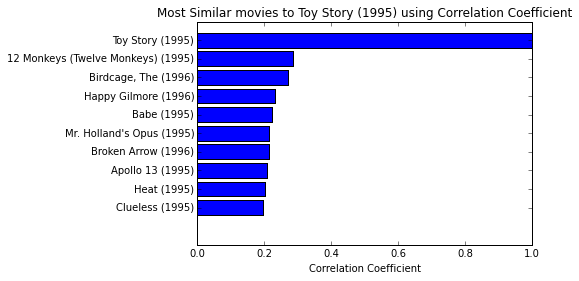

For movie, Pocahontas (1995), the sims are:
Pocahontas (1995)	1.0
Casper (1995)	0.394562856329
Jumanji (1995)	0.257935780318
Indian in the Cupboard, The (1995)	0.24819253163
First Knight (1995)	0.235220020274
Dangerous Minds (1995)	0.224136954865
Nine Months (1995)	0.223673014616
Free Willy 2: The Adventure Home (1995)	0.215536897183
Babe (1995)	0.210087870372
Mighty Morphin Power Rangers: The Movie (1995)	0.192526629073




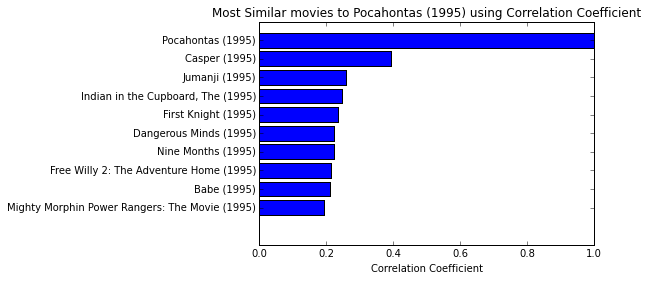

In [5]:
id_to_name = load_id_to_name('../MovieData/movies_new.dat')
name_to_id = load_name_to_id('../MovieData/movies_new.dat')
movie_vectors = counts.todense().transpose()
movie_name = 'Toy Story (1995)'
item_type = 'movies'
sim_type = 'Correlation Coefficient'
sims = top_correlated(movie_name, name_to_id, id_to_name, movie_vectors, 10)
plot_sims(movie_name, sims, item_type, sim_type, False)
movie_name = 'Pocahontas (1995)'
sims = top_correlated(movie_name, name_to_id, id_to_name, movie_vectors, 10)
print'For movie, %s, the sims are:'%(movie_name)
for movie, corr in sims:
    print movie + '\t' + str(corr)
print '\n'
plot_sims(movie_name,  sims, item_type, sim_type, False)



# Jaccard as a Similarity Function

In the correlation approach, we take into account the ratings. A simpler approach could be to assume that any indication of interest in the form of rating an item is by itself a signal. Given to sets $A$ and $B$, the Jaccard Similarity is 

$$ J(A,B) = \frac{\vert A\cap B\vert}{\vert{A\cup B}\vert} $$

Note that this is useful even in the case where ratings are not available. Say in Spotify where thumb up and thumb downs are available in Radio but everywhere else in the client, only implicit (play or no play) type data is available. 

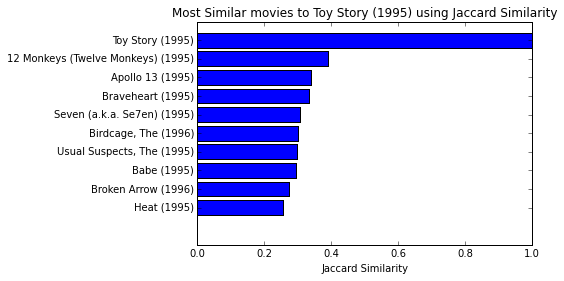

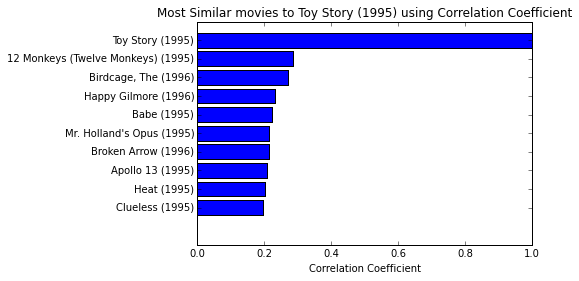

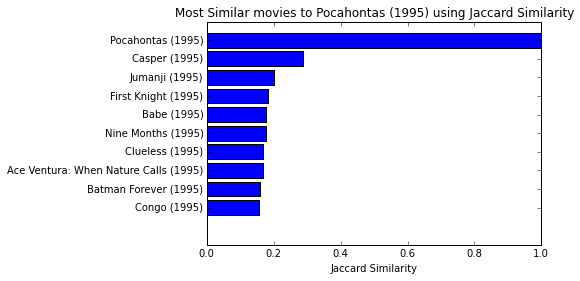

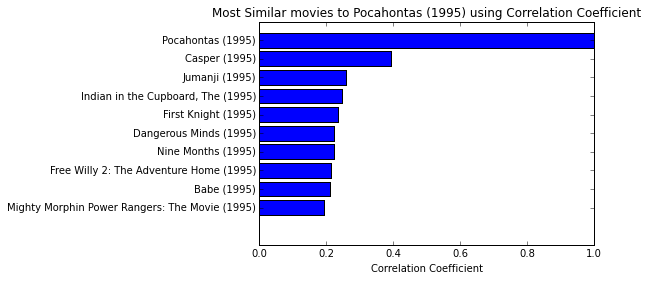

In [6]:
id_to_name = load_id_to_name('../MovieData/movies_new.dat')
name_to_id = load_name_to_id('../MovieData/movies_new.dat')
movie_vectors = counts.todense().transpose()
item_type = 'movies'
jacc = 'Jaccard Similarity'
corr = 'Correlation Coefficient'
movie_name = 'Toy Story (1995)'
jaccs = top_jaccard(movie_name, name_to_id, id_to_name, movie_vectors, 10)
corrs = top_correlated(movie_name, name_to_id, id_to_name, movie_vectors, 10)
plot_sims(movie_name,  jaccs, item_type, jacc, False)
plot_sims(movie_name, corrs, item_type, corr, False)
movie_name = 'Pocahontas (1995)'
jaccs = top_jaccard(movie_name, name_to_id, id_to_name, movie_vectors, 10)
corrs = top_correlated(movie_name, name_to_id, id_to_name, movie_vectors, 10)
plot_sims(movie_name, jaccs, item_type, jacc, False)
plot_sims(movie_name,  corrs, item_type, corr, False)


## Smoothing

When we have very few users rating an item, we find that a lot of the correlations are identical. This is essentially a form of overfitting. A way to avoid this is to add a regularizer. For correlation, a simple regularizer is to add some virtual counts. i.e. if $c$ is the total number of ratings for both items, add some non zero constant $w$ such that:

$$Corr(u,v) = \frac{c}{c + w}\frac{\sum_{i}u_{i}v_{i} -n\bar{u}\bar{v}}{\sqrt{n\sum_{i}u_{i}^2 - (\sum_{i}u_{i})^2}\sqrt{n\sum_{i}v_{i}^2 - (\sum_{i}v_{i})^2}}$$



In [7]:
counts_small = load_matrix('../MovieData/ratings_new.dat', 1000, 200)
counts_big = load_matrix('../MovieData/ratings_new.dat', 10000, 200)
id_to_name = load_id_to_name('../MovieData/movies_new.dat')
name_to_id = load_name_to_id('../MovieData/movies_new.dat')


Loaded 0 counts...
Finished loading matrix in 17.313865 seconds
Loaded 11054 data points
Loaded 0 counts...
Finished loading matrix in 17.107884 seconds
Loaded 112762 data points


/Users/eshvk/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:2471: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den


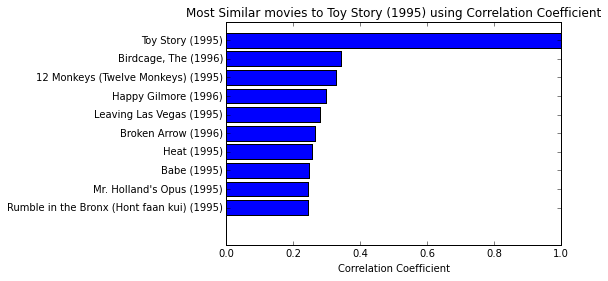

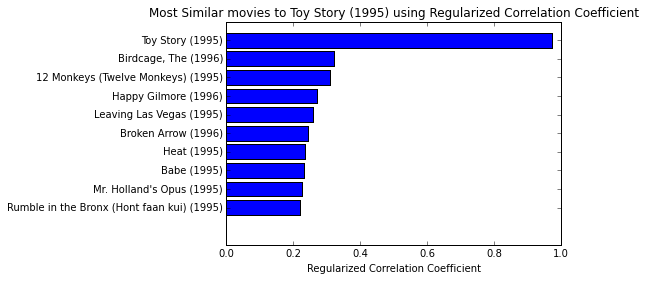

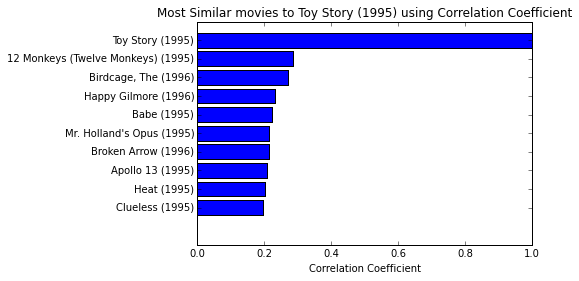

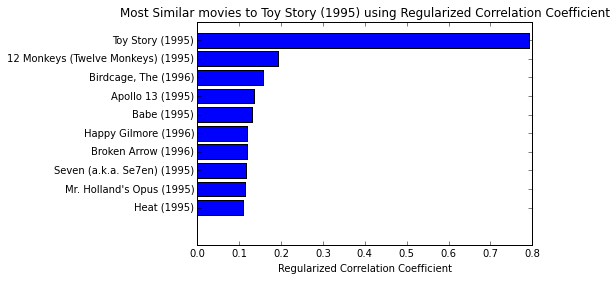

In [8]:
movie_vectors_1 = counts_small.todense().transpose()
movie_vectors_2 = counts_big.todense().transpose()
movie_name = 'Toy Story (1995)'
item_type = 'movies'
sim_type = 'Correlation Coefficient'
sims = top_correlated(movie_name, name_to_id, id_to_name, movie_vectors_1, 10)
reg_sims = top_reg_correlated(movie_name, name_to_id, id_to_name, movie_vectors_1, 10, 10)
plot_sims(movie_name,  sims, item_type, sim_type, False)
plot_sims(movie_name,  reg_sims, item_type, 'Regularized Correlation Coefficient', False)
sims = top_correlated(movie_name, name_to_id, id_to_name, movie_vectors_2, 10)
reg_sims = top_reg_correlated(movie_name, name_to_id, id_to_name, movie_vectors_2, 10, 1000)
plot_sims(movie_name,  sims, item_type, sim_type, False)
plot_sims(movie_name,  reg_sims, item_type, 'Regularized Correlation Coefficient', False)

#Content Based Approaches

What happens if you have no user ratings? You cannot process a matrix of all zeros and hope to acquire any information. This problem is also known as the [cold start problem](https://en.wikipedia.org/wiki/Cold_start). One approach out of this is to use external metadata, for example, Facebook likes or other Social N/W signals on the User side. Or metadata associated with items. 

For the GroupLens, dataset, we have associated with every movie, a set of genres. We can easily apply Jaccard Similarity on those. 

Loaded 0 counts...
Loaded 100000 counts...
Loaded 200000 counts...
Loaded 300000 counts...
Loaded 400000 counts...
Loaded 500000 counts...
Loaded 600000 counts...
Loaded 700000 counts...
Loaded 800000 counts...
Loaded 900000 counts...
Loaded 1000000 counts...
Loaded 1100000 counts...
Loaded 1200000 counts...
Loaded 1300000 counts...
Finished loading matrix in 19.614981 seconds
Loaded 1358203 data points


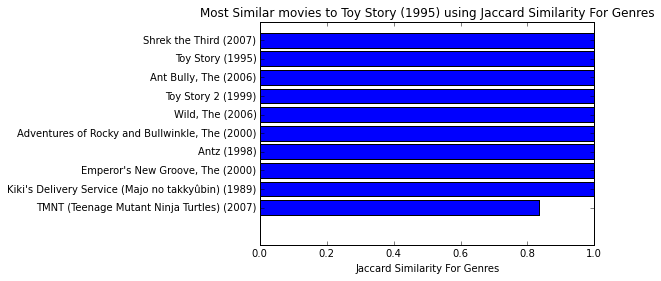

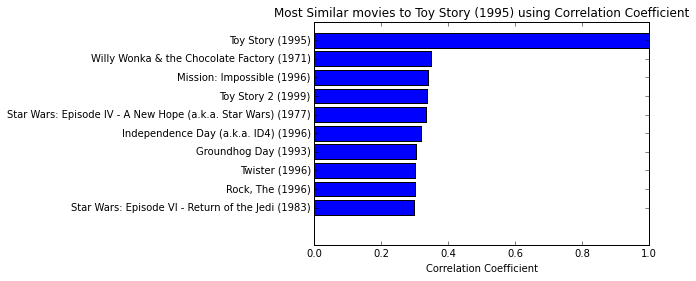

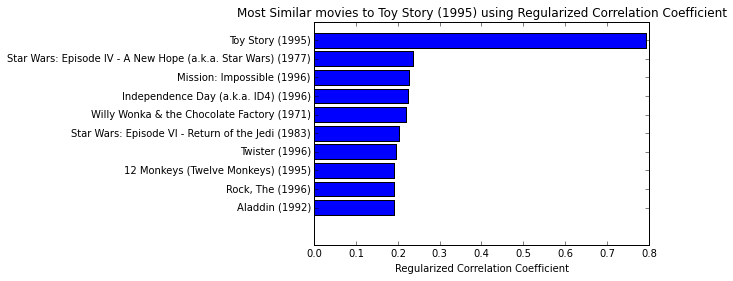

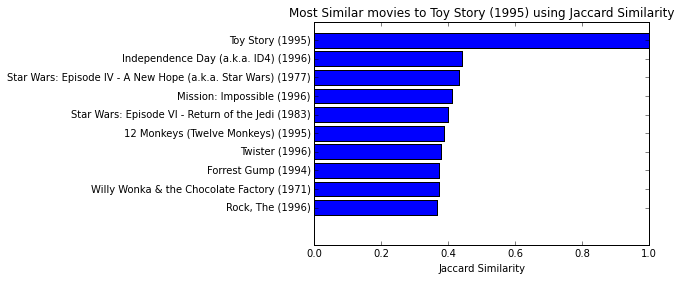

In [9]:
movie_genres = load_genres('../MovieData/movies_new.dat',10000)
counts_gigantic = load_matrix('../MovieData/ratings_new.dat', 10000, 10000)
item_type = 'movies'
movie_vectors = counts_gigantic.todense().transpose()
movie_name = 'Toy Story (1995)'
item_type = 'movies'
jacc_genres = top_genre_jaccard(movie_name, movie_genres, 10)
plot_sims(movie_name, jacc_genres, item_type, 'Jaccard Similarity For Genres', False)
sims = top_correlated(movie_name, name_to_id, id_to_name, movie_vectors, 10)
jacc_sims = top_jaccard(movie_name, name_to_id, id_to_name, movie_vectors, 10)
reg_sims = top_reg_correlated(movie_name, name_to_id, id_to_name, movie_vectors, 10, 1000)
plot_sims(movie_name,  sims, item_type, 'Correlation Coefficient', False)
plot_sims(movie_name,  reg_sims, item_type, 'Regularized Correlation Coefficient', False)
plot_sims(movie_name,  jacc_sims, item_type, 'Jaccard Similarity', False)



# Matrix Completion for Collaborative Filtering

The above rating based models form a family of models known as neighborhood based models. Specifically item-to-item Collaborative Filtering models. The advantage of the above models is that it is very quick to perform predictions for a user once they buy/interact with a certain item. 

The flipside is that global dependencies are not learnt. For example, historical information of a person's ratings. Furthermore, the problem of looking local is that transitive dependencies between items are also not learnt. 

 A different approach comes from the research done towards the [Netflix Challenge](http://www2.research.att.com/~volinsky/papers/ieeecomputer.pdf). We can model the user-item ratings data as an incomplete matrix. Then we take this matrix of  $n \times m$ user-item pairs of ratings $R$ and factorize it as the product of 2 lower-dimensional matrices $X^T$ and $Y$, where $X^T$ is an $n \times f$ matrix of user vectors and $Y$ is an $f \times m$ matrix of item vectors. Here, $f$ is the number of latent factors, which we usually choose to be much smaller than $n$ or $m$. At Spotify we generally choose f to be between $40$ and $100$.
 
 To solve for $X$ and $Y$, we attempt to minimize the weighted root mean squared error (RMSE) to the true ratings ($R$).  
 
 $$min_{x,y} \sum_{u,i \in R}(r_{u,i} - x_u^Ty_i - \mu - b_u - b_i)^2 +\lambda(\sum_u (\|x_u\|^2 + b_u^2) + \sum_i (\|y_i\|^2 + b_i^2)) $$
where

$r_{u,i} = $rating given by user $u$ to item $i$. 

$b_u = $ The bias of user $u$ in rating all items. Some users may be more generous than others...

$b_i = $ The bias in how this item $i$ is rated. Titanic might get rated higher on average than all other movies. 

$\mu = $ The global bias in the system. 

$\lambda = $ This is a regularization parameter. It ensures that overfitting to the observed data is avoided by penalizing higher magnitudes. 

This is a non-convex function in $X$ and $Y$. However, if we fix $X$ or fix $Y$, then the loss function becomes a weighted ridge regression loss ($\ell_2$-regularized linear regression) which is both convex and has a closed form solution.

$$min_{x} \sum_{u,i}(r_{u,i} - x_u^Ty_i -\mu - b_u - b_i)^2 +\lambda(\sum_u \|x_u\|^2 + b_u^2) $$

Taking the derivative of above and setting it to 0, we get:

$$x_u = (Y^T Y + \lambda I)^{-1} Y^T p_u$$

where 

$p_u \in \mathbf{R}^{m \times 1}$ is a vector where $p_{ui} = r_{ui} - b_{u} - b_{i} - \mu$. 

Similarily

$$y_i  = (X^T X + \lambda I)^{-1} X^T p_i$$


Then, we can solve for optimal $X$ and $Y$ by an alternating least squares procedure (ALS). First, we assign random gaussian noise to $X$ and $Y$. Then, we alternate between fixing $X$ and solving for $Y$ and fixing $Y$ and solving for $X$ until convergence.  Let us try to load the Group Lens dataset and try this approach. 


Loaded 0 counts...
Loaded 100000 counts...
Loaded 200000 counts...
Loaded 300000 counts...
Loaded 400000 counts...
Loaded 500000 counts...
Loaded 600000 counts...
Loaded 700000 counts...
Loaded 800000 counts...
Loaded 900000 counts...
Loaded 1000000 counts...
Loaded 1100000 counts...
Loaded 1200000 counts...
Loaded 1300000 counts...
Finished loading matrix in 20.579381 seconds
Loaded 1358203 data points


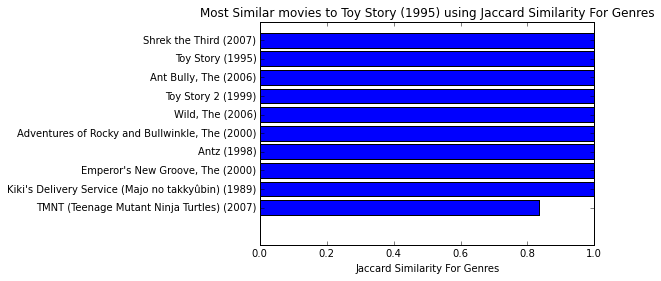

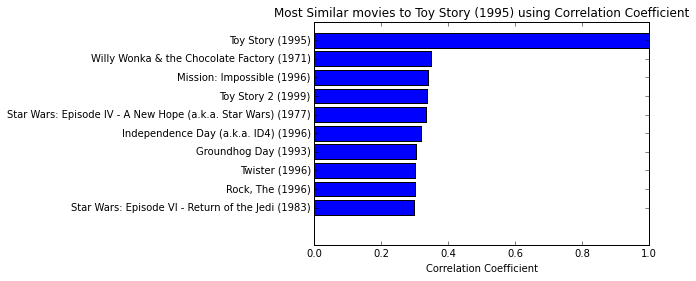

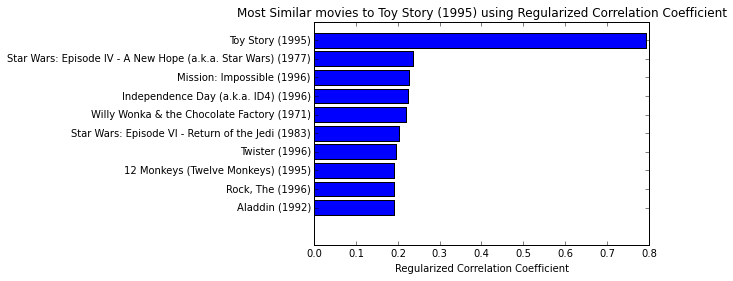

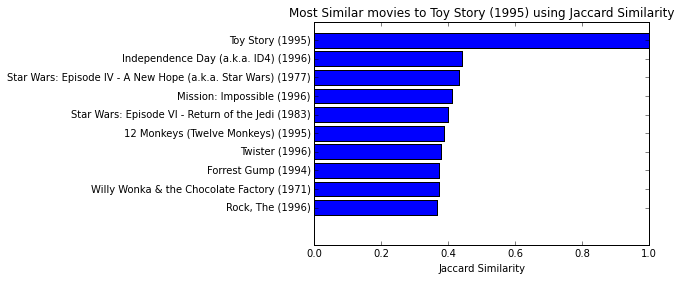

In [10]:
# From before
movie_genres = load_genres('../MovieData/movies_new.dat',10000)
counts_gigantic = load_matrix('../MovieData/ratings_new.dat', 10000, 10000)
item_type = 'movies'
movie_vectors = counts_gigantic.todense().transpose()
movie_name = 'Toy Story (1995)'
item_type = 'movies'
jacc_genres = top_genre_jaccard(movie_name, movie_genres, 10)
plot_sims(movie_name, jacc_genres, item_type, 'Jaccard Similarity For Genres', False)
sims = top_correlated(movie_name, name_to_id, id_to_name, movie_vectors, 10)
jacc_sims = top_jaccard(movie_name, name_to_id, id_to_name, movie_vectors, 10)
reg_sims = top_reg_correlated(movie_name, name_to_id, id_to_name, movie_vectors, 10, 1000)
plot_sims(movie_name,  sims, item_type, 'Correlation Coefficient', False)
plot_sims(movie_name,  reg_sims, item_type, 'Regularized Correlation Coefficient', False)
plot_sims(movie_name,  jacc_sims, item_type, 'Jaccard Similarity', False)



In [11]:
# Calculate biases first
global_bias, user_bias, item_bias = calculate_biases(counts_gigantic)

item_bias = np.array([x[0] if not np.isnan(x[0]) else 0.0 for x in item_bias])
user_bias = np.array([x[0] if not np.isnan(x[0]) else 0.0 for x in user_bias])



/Users/eshvk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:168: RuntimeWarning: invalid value encountered in double_scalars
/Users/eshvk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:169: RuntimeWarning: invalid value encountered in double_scalars


Next, let's train an MF model!

In [12]:
m = ExplicitMF(counts_gigantic, global_bias, user_bias, item_bias, num_iterations=20, num_factors=40)
m.train_model()

Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 1 seconds
Solved 2000 vecs in 1 seconds
Solved 3000 vecs in 1 seconds
Solved 4000 vecs in 1 seconds
Solved 5000 vecs in 1 seconds
Solved 6000 vecs in 1 seconds
Solved 7000 vecs in 1 seconds
Solved 8000 vecs in 1 seconds
Solved 9000 vecs in 1 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
Solved 4000 vecs in 4 seconds
Solved 5000 vecs in 4 seconds
Solved 6000 vecs in 4 seconds
Solved 7000 vecs in 4 seconds
Solved 8000 vecs in 3 seconds
Solved 9000 vecs in 3 seconds
iteration 1 finished in 55.551397 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 1 seconds
Solved 2000 vecs in 1 seconds
Solved 3000 vecs in 1 seconds
Solved 4000 vecs in 1 seconds
Solved 5000 vecs in 1 seconds
Solved 6000 vecs in 1 seconds
Solved 7000 vecs in 1 seconds
Solved 8000 vecs in 1 seconds
Solved 9000 v

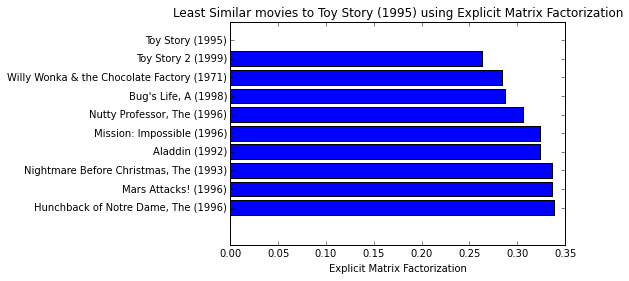

In [13]:
movie_name = 'Toy Story (1995)'
sims = top_cosine(movie_name, name_to_id, id_to_name,  m.item_vectors, least=False)
plot_sims(movie_name,  sims, 'movies', 'Explicit Matrix Factorization', True)

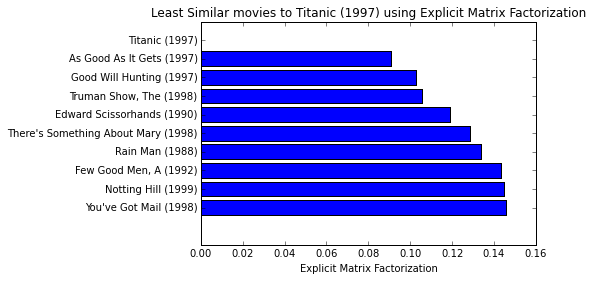

In [89]:
movie_name = 'Titanic (1997)'
sims = top_cosine(movie_name, name_to_id, id_to_name,  m.item_vectors, least=False)
plot_sims(movie_name,  sims, 'movies', 'Explicit Matrix Factorization', True)

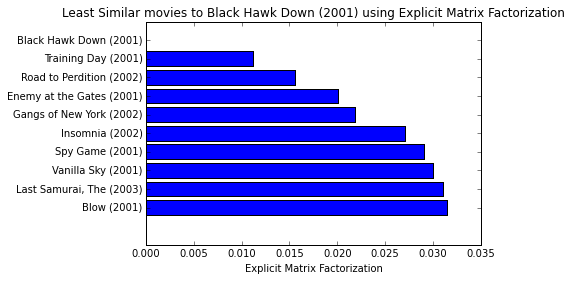

In [90]:
movie_name= 'Black Hawk Down (2001)'
sims = top_cosine(movie_name, name_to_id, id_to_name,  m.item_vectors, least=False)
plot_sims(movie_name,  sims, 'movies', 'Explicit Matrix Factorization', True)

# Implicit Matrix Factorization for Collaborative Filtering


You can find the original IMF paper by Hu et al. [here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.167.5120&rep=rep1&type=pdf)

Implicit Matrix Factorization (IMF) is a latent factor model used to model the relationship between users and items (track, album, artist, ...) based on implicit feedback (how many times did user <b>u</b> stream track <b>i</b>). The model is very similar to explicit Matrix Factorization except that the optimization equation changes a bit. 

To solve for $X$ and $Y$ we attempt to minimize the weighted root mean squared error (RMSE) to the true ratings ($R$). 

$$min_{x,y} \sum_{u,i}c_{u,i}(p_{u,i} - x_u^Ty_i)^2 +\lambda(\sum_u \|x_u\|^2 + \sum_i \|y_i\|^2) $$
where

$p_{u,i} = 1$ if user $u$ streamed track $i$ and $0$ otherwise

$c_{u,i} = 1 + \alpha r_{u,i}$

As before even though this is a non-convex function in $X$ and $Y$, if we fix $X$ or fix $Y$ then the loss function becomes a weighted ridge regression loss ($\ell_2$-regularized linear regression) which is both convex and has a closed form solution. 

$$min_{x} \sum_{u,i}c_{u,i}(p_{u,i} - x_u^Ty_i - b_u - b_i)^2 +\lambda(\sum_u \|x_u\|^2) $$

By taking the derivative of the above function, setting it to 0, and solving for $x$ we get

$$x_u = (Y^T C^u Y + \lambda I)^{-1} Y^T C^u p_u$$

where

$C^u$ is an $n \times n$ diagonal matrix such that $C^u_{i,i}=c_{u,i}$ 

We can further reduce this by factoring out $Y^TY$ to obtain

$$x_u = (Y^TY + Y^T(C^u - I)Y + \lambda I)^{-1} Y^T C^u p_u$$

Now you'll  train your own IMF model using real Spotify data. Specifically, you'll train an IMF model on the top $1k$ artists and $5k$ users. This amounts to a matrix with $706,905$ non-zero ratings.

In [91]:
# Main IMF Code
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import time

class ImplicitMF():

    def __init__(self, counts, global_bias, user_bias, item_bias, num_factors=10, num_iterations=20,
                 reg_param=0.8):
        self.counts = counts
        self.global_bias = global_bias
        self.user_bias = user_bias
        self.item_bias = item_bias
        self.num_users = counts.shape[0]
        self.num_items = counts.shape[1]
        self.num_factors = num_factors
        self.num_iterations = num_iterations
        self.reg_param = reg_param

    def train_model(self):
        self.user_vectors = np.random.normal(size=(self.num_users,
                                                   self.num_factors))
        self.item_vectors = np.random.normal(size=(self.num_items,
                                                   self.num_factors))

        for i in xrange(self.num_iterations):
            t0 = time.time()
            print 'Solving for user vectors...'
            self.user_vectors = self.iteration(True, sparse.csr_matrix(self.item_vectors))
            print 'Solving for item vectors...'
            self.item_vectors = self.iteration(False, sparse.csr_matrix(self.user_vectors))
            t1 = time.time()
            print 'iteration %i finished in %f seconds' % (i + 1, t1 - t0)

    def iteration(self, user, fixed_vecs):
        num_solve = self.num_users if user else self.num_items
        num_fixed = fixed_vecs.shape[0]
        YTY = fixed_vecs.T.dot(fixed_vecs)
        eye = sparse.eye(num_fixed)
        lambda_eye = self.reg_param * sparse.eye(self.num_factors)
        solve_vecs = np.zeros((num_solve, self.num_factors))

        t = time.time()
        for i in xrange(num_solve):
            if user:
                counts_i = self.counts[i].toarray()
            else:
                counts_i = self.counts[:, i].T.toarray()
            CuI = sparse.diags(counts_i, [0])
            pu = counts_i.copy()
            pu[np.where(pu != 0)] = 1.0
            YTCuIY = fixed_vecs.T.dot(CuI).dot(fixed_vecs)
            YTCupu = fixed_vecs.T.dot(CuI + eye).dot(sparse.csr_matrix(pu).T)
            xu = spsolve(YTY + YTCuIY + lambda_eye, YTCupu)
            solve_vecs[i] = xu
            if i % 1000 == 0:
                print 'Solved %i vecs in %d seconds' % (i, time.time() - t)
                t = time.time()

        return solve_vecs

Let us train an IMF model. First let's load the matrix of (user, artist, count) for the top 1k artists and 5k users on Spotify.

In [94]:
counts_music = load_matrix('../MusicData/user-artist-1k-2015-W09', 5000, 1000)
global_bias, user_bias, item_bias = calculate_biases(counts_music)
item_bias = np.array([x[0] if not np.isnan(x[0]) else 0.0 for x in item_bias])
user_bias = np.array([x[0] if not np.isnan(x[0]) else 0.0 for x in user_bias])
m = ImplicitMF(counts_music, global_bias, user_bias, item_bias, num_iterations=20, num_factors=40)
m.train_model()

Loaded 0 counts...
Loaded 100000 counts...
Loaded 200000 counts...
Loaded 300000 counts...
Loaded 400000 counts...
Loaded 500000 counts...
Loaded 600000 counts...
Loaded 700000 counts...
Finished loading matrix in 1.946472 seconds

/Users/eshvk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:151: RuntimeWarning: invalid value encountered in double_scalars
/Users/eshvk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:152: RuntimeWarning: invalid value encountered in double_scalars



Loaded 706905 data points
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 3 seconds
Solved 2000 vecs in 3 seconds
Solved 3000 vecs in 3 seconds
Solved 4000 vecs in 3 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
iteration 1 finished in 31.032689 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
Solved 4000 vecs in 3 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
iteration 2 finished in 33.118318 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 3 seconds
Solved 2000 vecs in 3 seconds
Solved 3000 vecs in 4 seconds
Solved 4000 vecs in 4 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
iteration 3 finished in 33.738077 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
Solved 4000 

Now that we have our model, we can use the vectors we learned to query for top Related Artists.

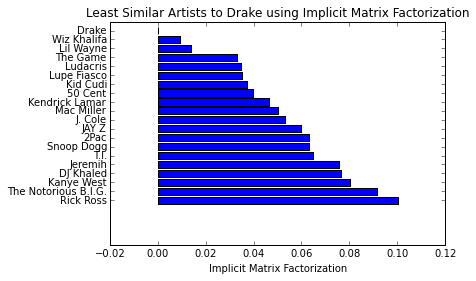

In [104]:
 id_to_name = load_mid_to_name('../Musicdata/id-to-name')
 uri_to_id = load_uri_to_id('../Musicdata/uri-to-id')
 drake_uri = 'spotify:artist:3TVXtAsR1Inumwj472S9r4'
 def most_similar_music(uri, vectors, max=30, least=False):
    id = uri_to_id[uri]
    vec = vectors[id]
    top_sims = []
    for (i, vec_b) in enumerate(vectors):
        if np.isnan(scipy.spatial.distance.cosine(vec, vec_b)):
            continue
        top_sims.append((i, (scipy.spatial.distance.cosine(vec, vec_b))))
    top_sims = sorted(top_sims, key = lambda x: x[1])[:max]
    return [(id_to_name[i], sim) for (i, sim) in top_sims]
 sims = most_similar_music(drake_uri, m.item_vectors, least=False)
 plot_sims(id_to_name[uri_to_id[drake_uri]], sims[:20], 'Artists', 'Implicit Matrix Factorization', True)
 

If we wanted to find Related Tracks for all tracks on Spotify this would require $O(n^2)$ comparisons which can be pretty slow even using MapReduce. Similarly, if we wanted to query for the top track recs for all users this would be $O(nm)$. To avoid comparing with every single track on Spotify we can use approximate nearest neighbors tricks using the annoy library.

Let's build an annoy forest consisting of 3 trees for our item vectors and use this to compute Related Artists.

In [105]:
from annoy import AnnoyIndex
tree = AnnoyIndex(40)
for i, vec in enumerate(m.item_vectors):
    tree.add_item(i, vec.tolist())
tree.build(3)
drake_id = uri_to_id[drake_uri]
[id_to_name[id] for id in tree.get_nns_by_item(drake_id, 20)]

['Drake',
 'Wiz Khalifa',
 'Lil Wayne',
 'The Game',
 'Ludacris',
 'Lupe Fiasco',
 'Kid Cudi',
 '50 Cent',
 'Kendrick Lamar',
 'Mac Miller',
 'J. Cole',
 'JAY Z',
 '2Pac',
 'Snoop Dogg',
 'T.I.',
 'DJ Khaled',
 'Kanye West',
 'The Notorious B.I.G.',
 'Rick Ross',
 'Busta Rhymes']

Notice that our Related Artists don't match the result we found earlier when comparing to all artists? That could be because we either have too few trees in our forest, or we didn't check enough leaf nodes.

Let's create a new annoy forest with 10 trees this time and also query for 100 related artists (only taking the top 20).

In [106]:
tree = AnnoyIndex(40)
for i, vec in enumerate(m.item_vectors):
    tree.add_item(i, vec.tolist())
tree.build(10)
[id_to_name[id] for id in tree.get_nns_by_item(drake_id, 100)][:20]

['Drake',
 'Wiz Khalifa',
 'Lil Wayne',
 'The Game',
 'Ludacris',
 'Lupe Fiasco',
 'Kid Cudi',
 '50 Cent',
 'Kendrick Lamar',
 'Mac Miller',
 'J. Cole',
 'JAY Z',
 '2Pac',
 'Snoop Dogg',
 'T.I.',
 'Jeremih',
 'DJ Khaled',
 'Kanye West',
 'The Notorious B.I.G.',
 'Rick Ross']

Increasing the number of trees used in your annoy forest will improve nearest neighbor accuracy, but will also require more memory to store. Additionally, requesting more nearest neighbors than you need may cause annoy to hit more leaf nodes and find more "closest" neighbors than it would have otherwise, however it will take more time as it requires more comparisons. These are tradeoffs that you'll need to decide upon for your application.